In [6]:
# 3 CELLS: NORMALIZE THEN SELECT ONLY > 50: 2 cells
import pandas as pd
import numpy as np

# Step 1: Read and preprocess the raw count data
df_raw = pd.read_csv('6048D_rawCounts.txt', sep='\t', index_col=0)

columns_of_interest = [
    'MR10_unmod_1', 'MR11_unmod_2', 'MR12_unmod_3',
    'MR1_NT_1', 'MR2_NT_2', 'MR3_NT_3',
    'MR4_Amide3_1', 'MR5_Amide3_2', 'MR6_Amide3_3',
    'MR7_GNA7_1', 'MR8_GNA7_2', 'MR9_GNA7_3'
]
df_counts = df_raw[columns_of_interest]

# Step 2: Normalize the counts
total_counts = df_counts.sum(axis=0)
scaling_factors = total_counts / total_counts.mean()
df_normalized = df_counts.div(scaling_factors, axis=1)

# Step 3: Calculate mean counts for each group
nt_cols = ['MR1_NT_1', 'MR2_NT_2', 'MR3_NT_3']
df_normalized['mean_nt'] = df_normalized[nt_cols].mean(axis=1)

unmod_cols = ['MR10_unmod_1', 'MR11_unmod_2', 'MR12_unmod_3']
amide_cols = ['MR4_Amide3_1', 'MR5_Amide3_2', 'MR6_Amide3_3']
gna_cols = ['MR7_GNA7_1', 'MR8_GNA7_2', 'MR9_GNA7_3']

df_normalized['mean_unmod'] = df_normalized[unmod_cols].mean(axis=1)
df_normalized['mean_amide'] = df_normalized[amide_cols].mean(axis=1)
df_normalized['mean_gna'] = df_normalized[gna_cols].mean(axis=1)

# Step 4: Print the dataframe
pd.set_option('display.max_colwidth', None)
print(df_normalized)
# df_normalized.to_csv('normalized_rawcounts.csv', index=True)



                 MR10_unmod_1  MR11_unmod_2  MR12_unmod_3    MR1_NT_1  \
ENSG00000000003    391.118668    361.915036    348.793455  401.479214   
ENSG00000000005      2.800372      0.000000      2.082349    4.523709   
ENSG00000000419    513.401593    623.108435    592.428285  478.382275   
ENSG00000000457    201.626807    216.807592    161.382046  144.758703   
ENSG00000000460    513.401593    518.972505    506.010803  477.251347   
...                       ...           ...           ...         ...   
ENSG00000286268      1.866915      0.000000      3.123523    0.000000   
ENSG00000286269      5.600745      1.707146      3.123523    7.916492   
ENSG00000286270      1.866915      1.707146      0.000000    2.261855   
ENSG00000286271      5.600745     13.657171      6.247047    3.392782   
ENSG00000286272      2.800372      0.000000      1.041174    2.261855   

                   MR2_NT_2    MR3_NT_3  MR4_Amide3_1  MR5_Amide3_2  \
ENSG00000000003  428.392850  485.653026    405.67666

In [2]:
df = df_normalized
df['unmod_avg'] = df[unmod_cols].mean(axis=1)
df['nt_avg'] = df[nt_cols].mean(axis=1)
df['amide_avg'] = df[amide_cols].mean(axis=1)
df['gna_avg'] = df[gna_cols].mean(axis=1)

df_filtered = df[(df[['unmod_avg', 'nt_avg', 'amide_avg', 'gna_avg']] >= 50).any(axis=1)]

df_filtered = df_filtered.drop(columns=['unmod_avg', 'nt_avg', 'amide_avg', 'gna_avg'])

# print(df_filtered.shape)
# print(df_filtered.head(1))


In [3]:
import pandas as pd #11297

# Step 1: Extract the IDs from df_filtered
df_filtered_ids = df_filtered.index.tolist()

# Step 2: Load the gene_alignments2.csv file
df_gene_alignments = pd.read_csv('gene_alignments.csv')

# Step 3: Filter the rows where the ensembl_id matches the filtered IDs
df_matched = df_gene_alignments[df_gene_alignments['ensembl_id'].isin(df_filtered_ids)]

# Step 4: Output the matched rows to gene_alignments3.csv
df_matched.to_csv('gene_alignments3.csv', index=False)


In [ ]:
### DOES ALIGNMENTS, BUT OUTPUTS THE WRONG IDS FOR UPDATED DATA. USES UPDATED IDS. ALSO DOESN'T USE BEST ALIGNMENTS. NO IDEA WHAT HAPPENED
import csv
from Bio import Align
import sys
csv.field_size_limit(sys.maxsize)
def load_id_mapping(mapping_file):
    id_map = {}
    with open(mapping_file, 'r') as csvfile:
        reader = csv.DictReader(csvfile)
        for row in reader:
            id_map[row['updated_id']] = row['original_id']
    return id_map

def reconstruct_gene_aligned(sequence, target_sequence, best_alignment):
    sequence_positions = best_alignment.aligned[0]
    target_positions = best_alignment.aligned[1]
    
    seq_start = sequence_positions[0][0]
    seq_end = sequence_positions[-1][1]
    
    target_start = target_positions[0][0]
    target_end = target_positions[-1][1]
    
    missing_bases_start = target_start
    missing_bases_end = len(target_sequence) - target_end
    
    seq_missing_start_index = max(0, seq_start - missing_bases_start)
    seq_missing_end_index = seq_end + missing_bases_end
    if seq_missing_end_index > len(sequence):
        seq_missing_end_index = len(sequence)
    
    seq_missing_start = sequence[seq_missing_start_index:seq_start]
    seq_aligned = sequence[seq_start:seq_end]
    seq_missing_end = sequence[seq_end:seq_missing_end_index]
    
    gene_aligned = seq_missing_start + seq_aligned + seq_missing_end
    return gene_aligned

def get_target_aligned(target_sequence, best_alignment):
    target_positions = best_alignment.aligned[1]
    target_aligned = ''
    for target_range in target_positions:
        target_aligned += target_sequence[target_range[0]:target_range[1]]
    return target_aligned

def scan_for_high_similarity(ensembl_id, sequence, csvwriter):
    aligner = Align.PairwiseAligner()
    aligner.mode = 'local'
    aligner.match_score = 2
    aligner.mismatch_score = -3
    aligner.open_gap_score = -5
    aligner.extend_gap_score = -2

    alignments = aligner.align(sequence, target_sequence)
    best_alignment = alignments[0] if alignments else None
    
    if best_alignment:
        gene_aligned = reconstruct_gene_aligned(sequence, target_sequence, best_alignment)
        target_aligned = get_target_aligned(target_sequence, best_alignment)
        print(f"{ensembl_id} {target_aligned} {gene_aligned}")


id_mapping = load_id_mapping('updated_ids.csv')
input_files = ['sequences.csv', 'sequences_from_updated.csv']
# input_files = ['sequences_from_updated.csv', 'sequences.csv']
target_sequence = "ATCTCCTAATATGAATCCTAT"


with open('gene_alignments.csv', 'w', newline='') as csvfile:
    csvwriter = csv.writer(csvfile)
    csvwriter.writerow(['ensembl_id', 'gene_aligned'])  # Write header

    for input_file in input_files:
        with open(input_file, 'r') as infile:
            reader = csv.DictReader(infile)
            
            for row in reader:
                ensembl_id = row['ensemble_id']
                sequence = row['sequence']
                
                if input_file == 'sequences_from_updated.csv':
                    ensembl_id = id_mapping.get(ensembl_id, ensembl_id)

                scan_for_high_similarity(ensembl_id, sequence, csvwriter)
                # break  # Break after the first entry


In [ ]:
## DOESN'T WORK RIGHT, PRODUCES SOME SHORT SEQUENCES, SOME LONG. LATEST ALIGNMENT, COLLECTS ALIGNED REGION AND 21MER FROM GENE. UPDATED IDS
import csv
from Bio import Align
import sys
csv.field_size_limit(sys.maxsize)

def load_id_mapping(mapping_file):
    id_map = {}
    with open(mapping_file, 'r') as csvfile:
        reader = csv.DictReader(csvfile)
        for row in reader:
            id_map[row['updated_id']] = row['original_id']
    return id_map

def reconstruct_gene_aligned(sequence, target_sequence, best_alignment):
    sequence_positions = best_alignment.aligned[0]
    target_positions = best_alignment.aligned[1]
    
    seq_start = sequence_positions[0][0]
    seq_end = sequence_positions[-1][1]
    
    target_start = target_positions[0][0]
    target_end = target_positions[-1][1]
    
    missing_bases_start = target_start
    missing_bases_end = len(target_sequence) - target_end
    
    seq_missing_start_index = max(0, seq_start - missing_bases_start)
    seq_missing_end_index = seq_end + missing_bases_end
    if seq_missing_end_index > len(sequence):
        seq_missing_end_index = len(sequence)
    
    seq_missing_start = sequence[seq_missing_start_index:seq_start]
    seq_aligned = sequence[seq_start:seq_end]
    seq_missing_end = sequence[seq_end:seq_missing_end_index]
    
    gene_aligned = seq_missing_start + seq_aligned + seq_missing_end
    return gene_aligned

def get_target_aligned(target_sequence, best_alignment):
    target_positions = best_alignment.aligned[1]
    target_aligned = ''
    for target_range in target_positions:
        target_aligned += target_sequence[target_range[0]:target_range[1]]
    return target_aligned

def scan_for_high_similarity(ensembl_id, sequence, csvwriter):
    # #########
    if ensembl_id != "ENSG00000044459":
        return
    aligner = Align.PairwiseAligner()
    aligner.mode = 'local'
    aligner.match_score = 2
    aligner.mismatch_score = -3
    aligner.open_gap_score = -5
    aligner.extend_gap_score = -2

    alignments = aligner.align(sequence, target_sequence)
    best_alignment = alignments[0] if alignments else None
    
    if best_alignment:
        gene_aligned = reconstruct_gene_aligned(sequence, target_sequence, best_alignment)
        target_aligned = get_target_aligned(target_sequence, best_alignment)
        print(f"{ensembl_id} {target_aligned} {gene_aligned}")  # Commented out the print statement

        target_rna = gene_aligned.replace('T', 'U')  # Perform T->U substitution
        print(f"{ensembl_id} {gene_aligned} {target_rna}")  # Commented out the print statement
        # csvwriter.writerow([ensembl_id, gene_aligned, target_rna])  # Write to CSV

id_mapping = load_id_mapping('updated_ids.csv')
input_files = ['sequences.csv', 'sequences_from_updated.csv']
target_sequence = "ATCTCCTAATATGAATCCTAT"
                    TCTCCTAATA        # 44459
                   TTCTCCTAATAACTGAATAAAAC ## LONG
                        CTAATATGAA 
                   CATAACTAATATCAACCTAT # SHORT ENSG00000007341,




with open('gene_alignments.csv', 'w', newline='') as csvfile:
    csvwriter = csv.writer(csvfile)
    csvwriter.writerow(['ensembl_id', 'gene_aligned', 'target_rna'])  # Write header

    for input_file in input_files:
        with open(input_file, 'r') as infile:
            reader = csv.DictReader(infile)
            
            for row in reader:
                ensembl_id = row['ensemble_id']
                sequence = row['sequence']
                
                if input_file == 'sequences_from_updated.csv':
                    ensembl_id = id_mapping.get(ensembl_id, ensembl_id)

                scan_for_high_similarity(ensembl_id, sequence, csvwriter)


In [15]:
## ALIGNMENTS. APPEARS TO BE WORKING!
import csv
import sys
from Bio import Align

def load_id_mapping(mapping_file):
    id_map = {}
    with open(mapping_file, 'r') as csvfile:
        reader = csv.DictReader(csvfile)
        for row in reader:
            id_map[row['updated_id']] = row['original_id']
    return id_map

def reconstruct_gene_aligned(sequence, target_sequence):
    aligner = Align.PairwiseAligner()
    aligner.mode = 'local'
    aligner.match_score = 2
    aligner.mismatch_score = -3
    aligner.open_gap_score = -5
    aligner.extend_gap_score = -2

    alignments = aligner.align(sequence, target_sequence)
    if not alignments:
        return None, None
    best_alignment = alignments[0]

    sequence_positions = best_alignment.aligned[0]
    target_positions = best_alignment.aligned[1]

    seq_start = sequence_positions[0][0]
    target_start = target_positions[0][0]

    adjusted_seq_start = seq_start - target_start
    adjusted_seq_start = max(0, adjusted_seq_start)

    adjusted_seq_end = adjusted_seq_start + len(target_sequence)
    adjusted_seq_end = min(len(sequence), adjusted_seq_end)

    gene_aligned = sequence[adjusted_seq_start:adjusted_seq_end]

    if len(gene_aligned) != len(target_sequence):
        if len(gene_aligned) > len(target_sequence):
            gene_aligned = gene_aligned[:len(target_sequence)]
        elif len(gene_aligned) < len(target_sequence):
            pass

    return gene_aligned, target_sequence

def scan_for_high_similarity(ensembl_id, sequence, csvwriter):
    # if ensembl_id != "ENSG00000002834":
    #     return

    gene_aligned, target_aligned = reconstruct_gene_aligned(sequence, target_sequence)

    if gene_aligned:
        target_rna = gene_aligned.replace('T', 'U')
        # print(f"{ensembl_id} {gene_aligned} {target_rna}")
        csvwriter.writerow([ensembl_id, gene_aligned, target_rna])
    else:
        print(f"{ensembl_id}: No alignment found.")

id_mapping = load_id_mapping('updated_ids.csv')
input_files = ['sequences.csv', 'sequences_from_updated.csv']
target_sequence = "ATCTCCTAATATGAATCCTAT"

with open('gene_alignments.csv', 'w', newline='') as csvfile:
    csvwriter = csv.writer(csvfile)
    csvwriter.writerow(['ensembl_id', 'gene_aligned', 'target_rna'])

    for input_file in input_files:
        with open(input_file, 'r') as infile:
            reader = csv.DictReader(infile)

            for row in reader:
                ensembl_id = row['ensemble_id']
                sequence = row['sequence']

                if input_file == 'sequences_from_updated.csv':
                    ensembl_id = id_mapping.get(ensembl_id, ensembl_id)

                scan_for_high_similarity(ensembl_id, sequence, csvwriter)


In [4]:
import sys
print(sys.path)

['/usr/lib/python311.zip', '/usr/lib/python3.11', '/usr/lib/python3.11/lib-dynload', '', '/data/home/mrichte3/.local/lib/python3.11/site-packages', '/usr/local/lib/python3.11/dist-packages', '/usr/lib/python3/dist-packages']


In [ ]:
## ALIGNMENTS. MULTIPLE ALIGNMENTS########################################################################################
import csv
import sys
from Bio import Align
csv.field_size_limit(sys.maxsize)

def load_id_mapping(mapping_file):
    id_map = {}
    with open(mapping_file, 'r') as csvfile:
        reader = csv.DictReader(csvfile)
        for row in reader:
            id_map[row['updated_id']] = row['original_id']
    return id_map

def reconstruct_gene_aligned(sequence, target_sequence):
    aligner = Align.PairwiseAligner()
    aligner.mode = 'local'
    aligner.match_score = 2
    aligner.mismatch_score = -3
    aligner.open_gap_score = -5
    aligner.extend_gap_score = -2

    alignments = aligner.align(sequence, target_sequence)
    if not alignments:
        return None, None
    best_alignment = alignments[0]
    sequence_positions = best_alignment.aligned[0]
    target_positions = best_alignment.aligned[1]



    seq_start = sequence_positions[0][0]
    target_start = target_positions[0][0]

    adjusted_seq_start = seq_start - target_start
    adjusted_seq_start = max(0, adjusted_seq_start)

    adjusted_seq_end = adjusted_seq_start + len(target_sequence)
    adjusted_seq_end = min(len(sequence), adjusted_seq_end)

    gene_aligned = sequence[adjusted_seq_start:adjusted_seq_end]

    if len(gene_aligned) != len(target_sequence):
        if len(gene_aligned) > len(target_sequence):
            gene_aligned = gene_aligned[:len(target_sequence)]
        elif len(gene_aligned) < len(target_sequence):
            pass

    return gene_aligned, target_sequence

def scan_for_high_similarity(ensembl_id, sequence, csvwriter):
    if ensembl_id != "ENSG00000051382":
        return

    gene_aligned, target_aligned = reconstruct_gene_aligned(sequence, target_sequence)

    if gene_aligned:
        target_rna = gene_aligned.replace('T', 'U')
        print(f"{ensembl_id} {gene_aligned} {target_rna}")
        csvwriter.writerow([ensembl_id, gene_aligned, target_rna])
    else:
        print(f"{ensembl_id}: No alignment found.")

id_mapping = load_id_mapping('updated_ids.csv')
input_files = ['sequences.csv', 'sequences_from_updated.csv']
target_sequence = "ATCTCCTAATATGAATCCTAT"

with open('multiple_gene_alignments.csv', 'w', newline='') as csvfile:
    csvwriter = csv.writer(csvfile)
    csvwriter.writerow(['ensembl_id', 'gene_aligned', 'target_rna'])

    for input_file in input_files:
        with open(input_file, 'r') as infile:
            reader = csv.DictReader(infile)

            for row in reader:
                ensembl_id = row['ensemble_id']
                sequence = row['sequence']

                if input_file == 'sequences_from_updated.csv':
                    ensembl_id = id_mapping.get(ensembl_id, ensembl_id)

                scan_for_high_similarity(ensembl_id, sequence, csvwriter)


In [ ]:
## 1/19/25 ALIGNMENTS. MULTIPLE ALIGNMENTS########################################################################################
import csv
import sys
from Bio import Align
csv.field_size_limit(sys.maxsize)

def load_id_mapping(mapping_file):
    id_map = {}
    with open(mapping_file, 'r') as csvfile:
        reader = csv.DictReader(csvfile)
        for row in reader:
            id_map[row['updated_id']] = row['original_id']
    return id_map

def reconstruct_gene_aligned(sequence, target_sequence):
    aligner = Align.PairwiseAligner()
    aligner.mode = 'local'
    aligner.match_score = 2
    aligner.mismatch_score = -3
    aligner.open_gap_score = -5
    aligner.extend_gap_score = -2

    alignments = aligner.align(sequence, target_sequence)
    if not alignments:
        return None, None
    best_alignment = alignments[0]
    sequence_positions = best_alignment.aligned[0]
    target_positions = best_alignment.aligned[1]



    seq_start = sequence_positions[0][0]
    target_start = target_positions[0][0]

    adjusted_seq_start = seq_start - target_start
    adjusted_seq_start = max(0, adjusted_seq_start)

    adjusted_seq_end = adjusted_seq_start + len(target_sequence)
    adjusted_seq_end = min(len(sequence), adjusted_seq_end)

    gene_aligned = sequence[adjusted_seq_start:adjusted_seq_end]

    if len(gene_aligned) != len(target_sequence):
        if len(gene_aligned) > len(target_sequence):
            gene_aligned = gene_aligned[:len(target_sequence)]
        elif len(gene_aligned) < len(target_sequence):
            pass

    return gene_aligned, target_sequence

def scan_for_high_similarity(ensembl_id, sequence, csvwriter):


    gene_aligned, target_aligned = reconstruct_gene_aligned(sequence, target_sequence)

    if gene_aligned:
        target_rna = gene_aligned.replace('T', 'U')
        print(f"{ensembl_id} {gene_aligned} {target_rna}")
        csvwriter.writerow([ensembl_id, gene_aligned, target_rna])
    else:
        print(f"{ensembl_id}: No alignment found.")

id_mapping = load_id_mapping('updated_ids.csv')
input_files = ['sequences.csv', 'sequences_from_updated.csv']
target_sequence = "ATCTCCTAATATGAATCCTAT"

with open('multiple_gene_alignments.csv', 'w', newline='') as csvfile:
    csvwriter = csv.writer(csvfile)
    csvwriter.writerow(['ensembl_id', 'gene_aligned', 'target_rna'])

    for input_file in input_files:
        with open(input_file, 'r') as infile:
            reader = csv.DictReader(infile)

            for row in reader:
                ensembl_id = row['ensemble_id']
                sequence = row['sequence']

                if input_file == 'sequences_from_updated.csv':
                    ensembl_id = id_mapping.get(ensembl_id, ensembl_id)

                scan_for_high_similarity(ensembl_id, sequence, csvwriter)
                if ensembl_id == "ENSG00000162496":
                    break


In [ ]:
## ALIGNMENTS. MULTIPLE ALIGNMENTS
import csv
import sys
from Bio import Align
import time
csv.field_size_limit(sys.maxsize)


def load_id_mapping(mapping_file):
    id_map = {}
    with open(mapping_file, 'r') as csvfile:
        reader = csv.DictReader(csvfile)
        for row in reader:
            id_map[row['updated_id']] = row['original_id']
    return id_map

def reconstruct_gene_aligned(sequence, target_sequence):
    # target_sequence = "ATATGAAT"
    aligner = Align.PairwiseAligner()
    aligner.mode = 'local'
    # aligner.mode = 'global'
    aligner.match_score = 2
    aligner.mismatch_score = -3 #-2 doesn't change anything. -1 produces a bunch of garbage.
    aligner.open_gap_score = -5
    aligner.extend_gap_score = -2

    alignments = aligner.align(sequence, target_sequence)
    if not alignments:
        return None, None
    best_alignment = alignments[0]
    sequence_positions = best_alignment.aligned[0]
    target_positions = best_alignment.aligned[1]
    # print("seq pos")
    # print(sequence_positions)
    # print("target pos")
    # print(target_positions)

###############################
    # aligned_targets = []
    # for alignment in alignments:
    #     target_positions = best_alignment.aligned[1]
    #     start, end = target_positions[0][0], target_positions[0][1]
    #     aligned_target_seq = target_sequence[start:end]
    #     aligned_targets.append(aligned_target_seq)
    # trimmed_target_sequence = aligned_targets[0][1:]
    # alignments = aligner.align(sequence, trimmed_target_sequence)
    # for alignment in alignments:
    #     target_positions = alignment.aligned[1]
    #     start, end = target_positions[0][0], target_positions[0][1]
    #     aligned_target_seq = trimmed_target_sequence[start:end]
    #     aligned_targets.append(aligned_target_seq)
######this works, but the trimmed_target_

#################
    for alignment in alignments:
        print("Score = %.1f:" % alignment.score)
        print(alignment)
        # time.sleep(10)
#################
    # n = 8
    # for i in range(len(target_sequence) - n + 1):
    #     subseq = target_sequence[i:i + n]
    #     gene_aligned, target_aligned = reconstruct_gene_aligned(sequence, subseq)
#############

    seq_start = sequence_positions[0][0]
    target_start = target_positions[0][0]

    adjusted_seq_start = seq_start - target_start
    adjusted_seq_start = max(0, adjusted_seq_start)

    adjusted_seq_end = adjusted_seq_start + len(target_sequence)
    adjusted_seq_end = min(len(sequence), adjusted_seq_end)

    gene_aligned = sequence[adjusted_seq_start:adjusted_seq_end]

    if len(gene_aligned) != len(target_sequence):
        if len(gene_aligned) > len(target_sequence):
            gene_aligned = gene_aligned[:len(target_sequence)]
        elif len(gene_aligned) < len(target_sequence):
            pass

    return gene_aligned, target_sequence

def scan_for_high_similarity(ensembl_id, sequence, csvwriter):
    # if ensembl_id != "ENSG00000051382":
    #     return
    if ensembl_id != "ENSG00000000003":
        return

    gene_aligned, target_aligned = reconstruct_gene_aligned(sequence, target_sequence)

    if gene_aligned:
        target_rna = gene_aligned.replace('T', 'U')
        print(f"{ensembl_id} {gene_aligned} {target_rna}")
        csvwriter.writerow([ensembl_id, gene_aligned, target_rna])
    else:
        print(f"{ensembl_id}: No alignment found.")

id_mapping = load_id_mapping('updated_ids.csv')
input_files = ['sequences.csv', 'sequences_from_updated.csv']
target_sequence = "ATCTCCTAATATGAATCCTAT"

with open('multiple_gene_alignments.csv', 'w', newline='') as csvfile:
    csvwriter = csv.writer(csvfile)
    csvwriter.writerow(['ensembl_id', 'gene_aligned', 'target_rna'])

    for input_file in input_files:
        with open(input_file, 'r') as infile:
            reader = csv.DictReader(infile)

            for row in reader:
                ensembl_id = row['ensemble_id']
                sequence = row['sequence']

                if input_file == 'sequences_from_updated.csv':
                    ensembl_id = id_mapping.get(ensembl_id, ensembl_id)

                scan_for_high_similarity(ensembl_id, sequence, csvwriter)


In [ ]:
## 2 CELLS: NORMALIZE DATA, THEN SHOW VARIATION LEVELS AS THE COUNTS GET LOWER
import pandas as pd
import numpy as np

# Step 1: Read and preprocess the raw count data
df_raw = pd.read_csv('6048D_rawCounts.txt', sep='\t', index_col=0)

columns_of_interest = [
    'MR10_unmod_1', 'MR11_unmod_2', 'MR12_unmod_3',
    'MR1_NT_1', 'MR2_NT_2', 'MR3_NT_3',
    'MR4_Amide3_1', 'MR5_Amide3_2', 'MR6_Amide3_3',
    'MR7_GNA7_1', 'MR8_GNA7_2', 'MR9_GNA7_3'
]
df_counts = df_raw[columns_of_interest]

# Step 2: Normalize the counts
total_counts = df_counts.sum(axis=0)
scaling_factors = total_counts / total_counts.mean()
df_normalized = df_counts.div(scaling_factors, axis=1)

# Step 3: Calculate mean counts for each group
nt_cols = ['MR1_NT_1', 'MR2_NT_2', 'MR3_NT_3']
df_normalized['mean_nt'] = df_normalized[nt_cols].mean(axis=1)

unmod_cols = ['MR10_unmod_1', 'MR11_unmod_2', 'MR12_unmod_3']
amide_cols = ['MR4_Amide3_1', 'MR5_Amide3_2', 'MR6_Amide3_3']
gna_cols = ['MR7_GNA7_1', 'MR8_GNA7_2', 'MR9_GNA7_3']

df_normalized['mean_unmod'] = df_normalized[unmod_cols].mean(axis=1)
df_normalized['mean_amide'] = df_normalized[amide_cols].mean(axis=1)
df_normalized['mean_gna'] = df_normalized[gna_cols].mean(axis=1)

# Step 4: Print the dataframe
print(df_normalized)



In [9]:
# Calculate coefficient of variation (CV) for each group of columns separately
#    Count_Group  Unmod_CV     NT_CV  Amide_CV    GNA_CV
# 0         0-10  1.068162  1.027219  0.953847  1.105614
# 1        10-20  0.491206  0.391281  0.290801  0.279560
# 2        20-30  0.354620  0.289134  0.207708  0.203863
# 3        30-40  0.263930  0.236593  0.165240  0.170601
# 4        40-50  0.218105  0.208697  0.151923  0.150070
# 5        50-60  0.177923  0.185138  0.137048  0.133754
# 6        60-70  0.154457  0.170986  0.126895  0.124986
# 7        70-80  0.146149  0.157443  0.113342  0.121172
# 8        80-90  0.134715  0.139014  0.110866  0.109366
# 9       90-100  0.128617  0.147879  0.103076  0.095210
# 10     100-110  0.105187  0.140109  0.096870  0.104915
df['unmod_std_dev'] = df[unmod_cols].std(axis=1)
df['unmod_mean'] = df[unmod_cols].mean(axis=1)
df['unmod_cv'] = df['unmod_std_dev'] / df['unmod_mean']

df['nt_std_dev'] = df[nt_cols].std(axis=1)
df['nt_mean'] = df[nt_cols].mean(axis=1)
df['nt_cv'] = df['nt_std_dev'] / df['nt_mean']

df['amide_std_dev'] = df[amide_cols].std(axis=1)
df['amide_mean'] = df[amide_cols].mean(axis=1)
df['amide_cv'] = df['amide_std_dev'] / df['amide_mean']

df['gna_std_dev'] = df[gna_cols].std(axis=1)
df['gna_mean'] = df[gna_cols].mean(axis=1)
df['gna_cv'] = df['gna_std_dev'] / df['gna_mean']

# Step 2: Define the groups based on mean count
bins = list(range(0, 1010, 10))  # Create bins from 0 to 1000 in steps of 10
labels = [f'{i}-{i+10}' for i in range(0, 1000, 10)]  # Generate labels like '0-10', '10-20', etc.

df['unmod_count_group'] = pd.cut(df['unmod_mean'], bins=bins, labels=labels, right=False)
df['nt_count_group'] = pd.cut(df['nt_mean'], bins=bins, labels=labels, right=False)
df['amide_count_group'] = pd.cut(df['amide_mean'], bins=bins, labels=labels, right=False)
df['gna_count_group'] = pd.cut(df['gna_mean'], bins=bins, labels=labels, right=False)

# Step 3: Calculate the average CV within each group for all four groups
grouped_unmod = df.groupby('unmod_count_group')['unmod_cv'].mean().reset_index()
grouped_nt = df.groupby('nt_count_group')['nt_cv'].mean().reset_index()
grouped_amide = df.groupby('amide_count_group')['amide_cv'].mean().reset_index()
grouped_gna = df.groupby('gna_count_group')['gna_cv'].mean().reset_index()

# Rename the columns to match the group names
grouped_unmod.columns = ['Count_Group', 'Unmod_CV']
grouped_nt.columns = ['Count_Group', 'NT_CV']
grouped_amide.columns = ['Count_Group', 'Amide_CV']
grouped_gna.columns = ['Count_Group', 'GNA_CV']

# Step 4: Merge all the grouped data into a single DataFrame
final_grouped = pd.merge(grouped_unmod, grouped_nt, on='Count_Group', how='outer')
final_grouped = pd.merge(final_grouped, grouped_amide, on='Count_Group', how='outer')
final_grouped = pd.merge(final_grouped, grouped_gna, on='Count_Group', how='outer')

# Step 5: Save the final result as a CSV
final_grouped.to_csv('grouped_variation.csv', index=False)

# Step 6: Output the final result
print(final_grouped)


   Count_Group  Unmod_CV     NT_CV  Amide_CV    GNA_CV
0         0-10  1.068162  1.027219  0.953847  1.105614
1        10-20  0.491206  0.391281  0.290801  0.279560
2        20-30  0.354620  0.289134  0.207708  0.203863
3        30-40  0.263930  0.236593  0.165240  0.170601
4        40-50  0.218105  0.208697  0.151923  0.150070
5        50-60  0.177923  0.185138  0.137048  0.133754
6        60-70  0.154457  0.170986  0.126895  0.124986
7        70-80  0.146149  0.157443  0.113342  0.121172
8        80-90  0.134715  0.139014  0.110866  0.109366
9       90-100  0.128617  0.147879  0.103076  0.095210
10     100-110  0.105187  0.140109  0.096870  0.104915
11     110-120  0.108144  0.130725  0.092110  0.090189
12     120-130  0.104069  0.132695  0.084602  0.084015
13     130-140  0.103812  0.128588  0.079789  0.083048
14     140-150  0.097525  0.119639  0.084714  0.084546
15     150-160  0.090663  0.128432  0.074878  0.085519
16     160-170  0.097823  0.123122  0.085007  0.081275
17     170

/tmp/ipykernel_535073/4145599135.py:28: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_unmod = df.groupby('unmod_count_group')['unmod_cv'].mean().reset_index()
/tmp/ipykernel_535073/4145599135.py:29: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_nt = df.groupby('nt_count_group')['nt_cv'].mean().reset_index()
/tmp/ipykernel_535073/4145599135.py:30: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_amide

In [4]:
## FINDING INVALID ENTRIES FROM GENE_ALIGNMENTS2
import csv

# Open the gene_alignments2.csv and gene_alignments3.csv
with open('gene_alignments2.csv', 'r') as file2, open('gene_alignments3.csv', 'r') as file3:
    reader2 = csv.DictReader(file2)
    reader3 = csv.DictReader(file3)
    
    # Create lists of rows from each file
    data2 = {row['ensembl_id']: row['gene_aligned'] for row in reader2}
    data3 = {row['ensembl_id']: row['gene_aligned'] for row in reader3}

# Compare the gene_aligned values and store mismatches
incorrect_alignments = []
for ensembl_id in data2:
    if ensembl_id in data3 and data2[ensembl_id] != data3[ensembl_id]:
        incorrect_alignments.append({
            'ensembl_id': ensembl_id,
            'gene_aligned_2': data2[ensembl_id],
            'gene_aligned_3': data3[ensembl_id]
        })

# Write the mismatches to incorrect_gene_alignments.csv
with open('incorrect_gene_alignments.csv', 'w', newline='') as outfile:
    writer = csv.DictWriter(outfile, fieldnames=['ensembl_id', 'gene_aligned_2', 'gene_aligned_3'])
    writer.writeheader()
    writer.writerows(incorrect_alignments)


In [5]:
import os
import shutil
import csv

# Create the destination directory if it doesn't exist
destination_dir = 'output_cifs/incorrect_guide'
if not os.path.exists(destination_dir):
    os.makedirs(destination_dir)

# Open the incorrect_gene_alignments.csv and collect ensembl_id values
ensembl_ids = []
with open('incorrect_gene_alignments.csv', 'r') as infile:
    reader = csv.DictReader(infile)
    for row in reader:
        ensembl_ids.append(row['ensembl_id'])

# Directory containing the .cif files
source_dir = 'output_cifs'

# Move the files matching ensembl_id.cif to the new directory
for ensembl_id in ensembl_ids:
    cif_file = os.path.join(source_dir, f'{ensembl_id}.cif')
    if os.path.exists(cif_file):
        shutil.move(cif_file, destination_dir)


In [ ]:
### TRYING A REDO
import pandas as pd
from pathlib import Path
import torch
from chai_lab.chai1 import run_inference
import shutil
import sys

def main(gpu_index):
    ensembl_id = 'ENSG00000092108'  # Specific ID to process

    df = pd.read_csv('gene_alignments3.csv')
    print(f"Loaded CSV file with {len(df)} rows")

    # Find the specific row for the given ensembl_id
    row = df[df['ensembl_id'] == ensembl_id].iloc[0]
    target_rna = row['target_rna']
    
    print(f"Processing ensembl_id: {ensembl_id}, target_rna: {target_rna}")

    example_fasta = f""">protein|PIK3CB
MYSGAGPALAPPAPPPPIQGYAFKPPPRPDFGTSGRTIKLQANFFEMDIPKIDIYHYELDIKPEKCPRRVNREIVEHMVQHFKTQIFGDRKPVFDGRKNLYTAMPLPIGRDKVELEVTLPGEGKDRIFKVSIKWVSCVSLQALHDALSGRLPSVPFETIQALDVVMRHLPSMRYTPVGRSFFTASEGCSNPLGGGREVWFGFHQSVRPSLWKMMLNIDVSATAFYKAQPVIEFVCEVLDFKSIEEQQKPLTDSQRVKFTKEIKGLKVEITHCGQMKRKYRVCNVTRRPASHQTFPLQQESGQTVECTVAQYFKDRHKLVLRYPHLPCLQVGQEQKHTYLPLEVCNIVAGQRCIKKLTDNQTSTMIRATARSAPDRQEEISKLMRSADFNTDPYVREFGIMVKDEMTDVTGRVLQPPSILYGGRNKAIATPVQGVWDMRNKQFHTGIEIKVWAIACFAPQRQCTEVHLKSFTEQLRKISRDAGMPIQGQPCFCKYAQGADSVEPMFRHLKNTYAGLQLVVVILPGKTPVYAEVKRVGDTVLGMATQCVQMKNVQRTTPQTLSNLCLKINVKLGGVNNILLPQGRPPVFQQPVIFLGADVTHPPAGDGKKPSIAAVVGSMDAHPNRYCATVRVQQHRQEIIQDLAAMVRELLIQFYKSTRFKPTRIIFYRAGVSEGQFQQVLHHELLAIREACIKLEKDYQPGITFIVVQKRHHTRLFCTDKNERVGKSGNIPAGTTVDTKITHPTEFDFYLCSHAGIQGTSRPSHYHVLWDDNRFSSDELQILTYQLCHTYVRCTRSVSIPAPAYYAHLVAFRARYHLVDKEHDAAEGDHTDGQANGRDHQALAKAVQVHQDTLRTMYFA
>rna|AUAGGACUCAUAUUAGGAGAU
AUAGGACUCAUAUUAGGAGAU
>rna|PIK3CB_AUAGGACUCAUAUUAGGAGAU_{ensembl_id}_{target_rna}
{target_rna}"""

    fasta_path = Path(f"fasta/{gpu_index}.fasta")
    fasta_path.write_text(example_fasta)
    print(f"FASTA file written to {fasta_path}")

    output_dir = Path(f"outputdirs/output{gpu_index}")
    output_cif_paths = run_inference(
        fasta_file=fasta_path,
        output_dir=output_dir,
        num_trunk_recycles=3,
        num_diffn_timesteps=200,
        seed=42,
        device=torch.device("cuda:0"),  # Use "cpu" if no GPU is available
        use_esm_embeddings=True,
    )

    cif_file = output_dir / "pred.model_idx_0.cif"
    if cif_file.exists():
        new_cif_name = Path(f"ENSG00000092108_redo.cif")
        shutil.move(str(cif_file), str(new_cif_name))
        print(f"Moved {cif_file} to {new_cif_name}")
    else:
        print(f"File {cif_file} does not exist")

if __name__ == "__main__":
    gpu_index = 1  # Set GPU index explicitly to 1 for processing
    main(gpu_index)


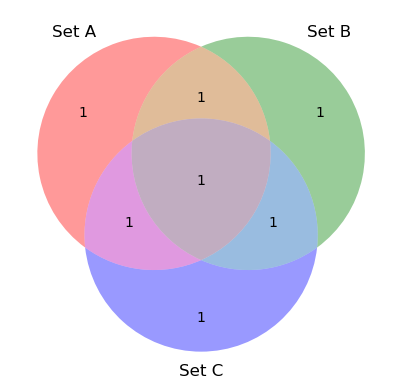

In [1]:
import matplotlib.pyplot as plt
from matplotlib_venn import venn3

# Define your sets
set_A = {'A', 'B', 'C', 'D'}
set_B = {'B', 'C', 'E', 'F'}
set_C = {'C', 'D', 'F', 'G'}

# Create the Venn diagram
venn3([set_A, set_B, set_C], ('Set A', 'Set B', 'Set C'))
plt.show()

In [ ]:
# Load necessary libraries
library(dplyr)
library(readr)

# Load the data
df <- read_csv("6048-DEgenes_log2fc_padj.csv")

# Select required columns
df <- df %>%
  select(GeneID, log2fc_amide, padj_amide, log2fc_gna, padj_gna, log2fc_unmod, padj_unmod)

# Convert 'log2fc_unmod' to numeric and adjust values
df$log2fc_unmod <- as.numeric(df$log2fc_unmod)
df$log2fc_unmod[!is.na(df$log2fc_unmod)] <- -df$log2fc_unmod[!is.na(df$log2fc_unmod)]

# Create separate dataframes
df_amide <- df %>% select(GeneID, log2fc_amide, padj_amide) %>% slice(1:(n() - 1))
df_gna <- df %>% select(GeneID, log2fc_gna, padj_gna) %>% slice(1:(n() - 1))
df_unmod <- df %>% select(GeneID, log2fc_unmod, padj_unmod) %>% slice(1:(n() - 1))

# Filter based on p-adjusted values
df_amide <- df_amide %>% filter(as.numeric(padj_amide) <= 0.05)
df_gna <- df_gna %>% filter(as.numeric(padj_gna) <= 0.05)
df_unmod <- df_unmod %>% filter(as.numeric(padj_unmod) <= 0.05)

# Convert to sets
set_amide <- unique(df_amide$GeneID)
set_gna <- unique(df_gna$GeneID)
set_unmod <- unique(df_unmod$GeneID)


In [9]:
# install.packages("VennDiagram", repos = "http://cran.us.r-project.org")
.libPaths("/data/home/mrichte3/rlibs")

# install.packages("VennDiagram", repos = "http://cran.us.r-project.org")
# library(VennDiagram)


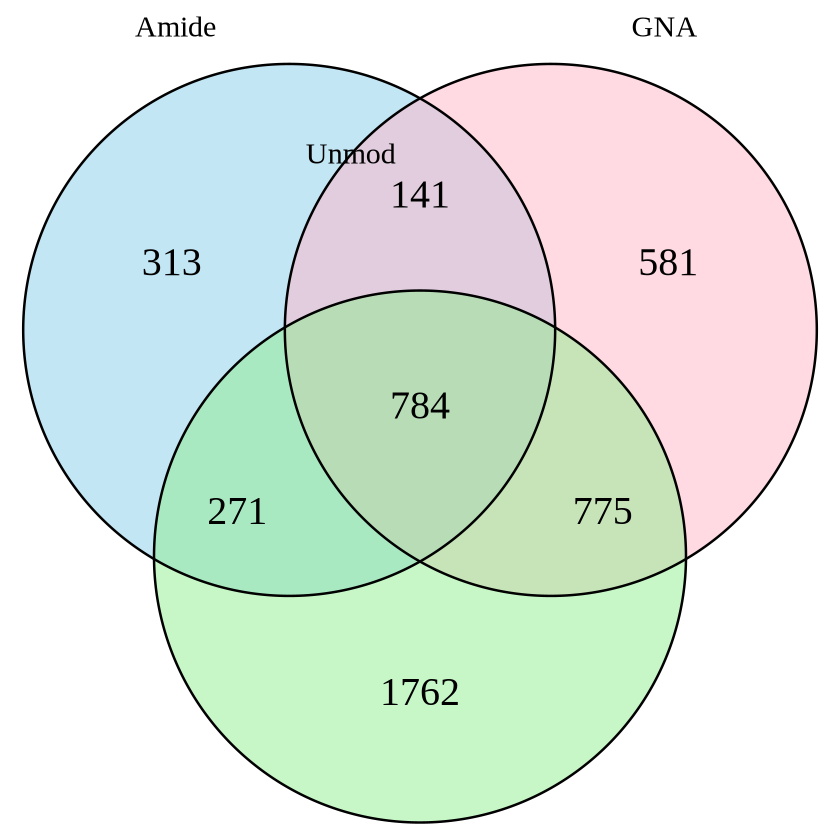

In [4]:
library(VennDiagram)
library(grid)

venn.plot <- venn.diagram(
  x = list(
    Amide = set_amide,
    GNA = set_gna,
    Unmod = set_unmod
  ),
  filename = NULL,
  col = "black",
  fill = c("skyblue", "pink1", "lightgreen"),
  alpha = 0.5,
  cex = 2,
  cat.cex = 1.5,
  cat.pos = c(-20, 20, -10),  # Adjusted Unmod label position
  cat.dist = c(0.05, 0.05, 0.1)  # Adjusted Unmod label distance
)

grid.newpage()
grid.draw(venn.plot)


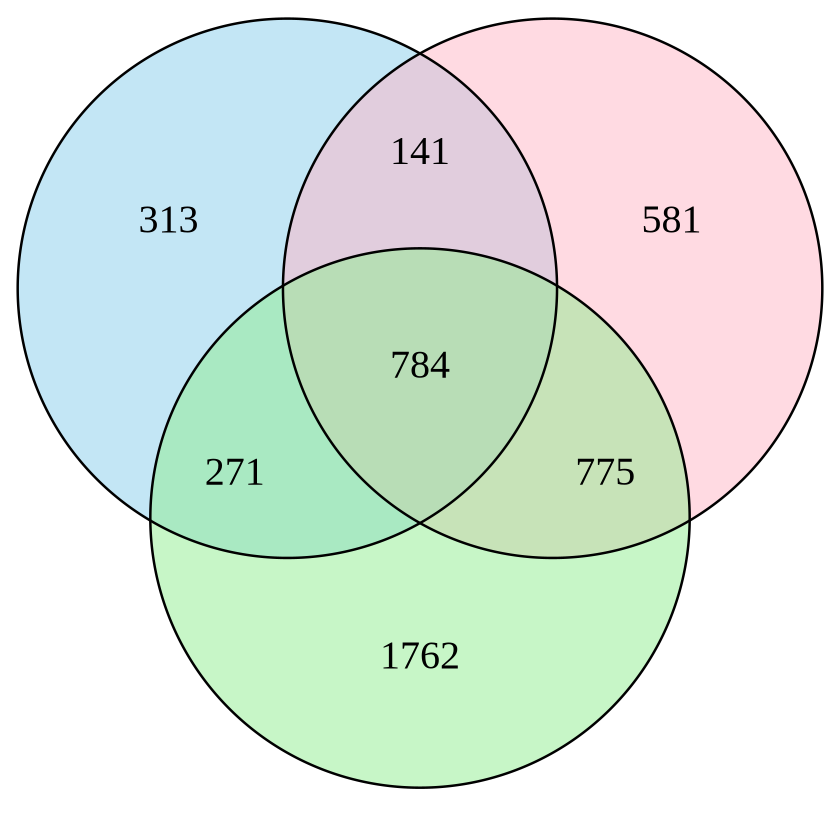

In [5]:
library(VennDiagram)
library(grid)

venn.plot <- venn.diagram(
  x = list(
    Amide = set_amide,
    GNA = set_gna,
    Unmod = set_unmod
  ),
  filename = NULL,
  col = "black",
  fill = c("skyblue", "pink1", "lightgreen"),
  alpha = 0.5,
  cex = 2,
  cat.cex = 0  # Remove labels
)

grid.newpage()
grid.draw(venn.plot)


In [3]:
# library(VennDiagram)
# library(grid)

# Add your custom fonts directory to the system
# If already set globally, you can skip this step
system("fc-cache -fv")
Sys.setenv(FONTCONFIG_PATH = "/data/home/mrichte3/rlibs/fonts")

# Set Arial globally
par(family = "Arial")

arial_fonts <- system("fc-list | grep -i arial", intern = TRUE)
print(arial_fonts)

# # Create Venn diagram
# venn.plot <- venn.diagram(
#   x = list(
#     Amide = set_amide,
#     GNA = set_gna,
#     Unmod = set_unmod
#   ),
#   filename = NULL,
#   col = "black",  # Black outline for the circles
#   fill = c("skyblue", "pink1", "lightgreen"),  # Fill colors
#   alpha = 0.5,  # Transparency
#   cex = 2,  # Font size for counts
#   cat.cex = 0  # Remove labels for categories
# )

# # Draw the Venn diagram
# grid.newpage()
# grid.draw(venn.plot)

# Reset to default font
par(family = "")


Warning message in system("fc-list | grep -i arial", intern = TRUE):
“running command 'fc-list | grep -i arial' had status 1”


character(0)
attr(,"status")
[1] 1
attr(,"errmsg")
[1] "Resource temporarily unavailable"


Warning message in plot.window(...):
“"fontfamily" is not a graphical parameter”
Warning message in plot.xy(xy, type, ...):
“"fontfamily" is not a graphical parameter”
Warning message in title(...):
“"fontfamily" is not a graphical parameter”


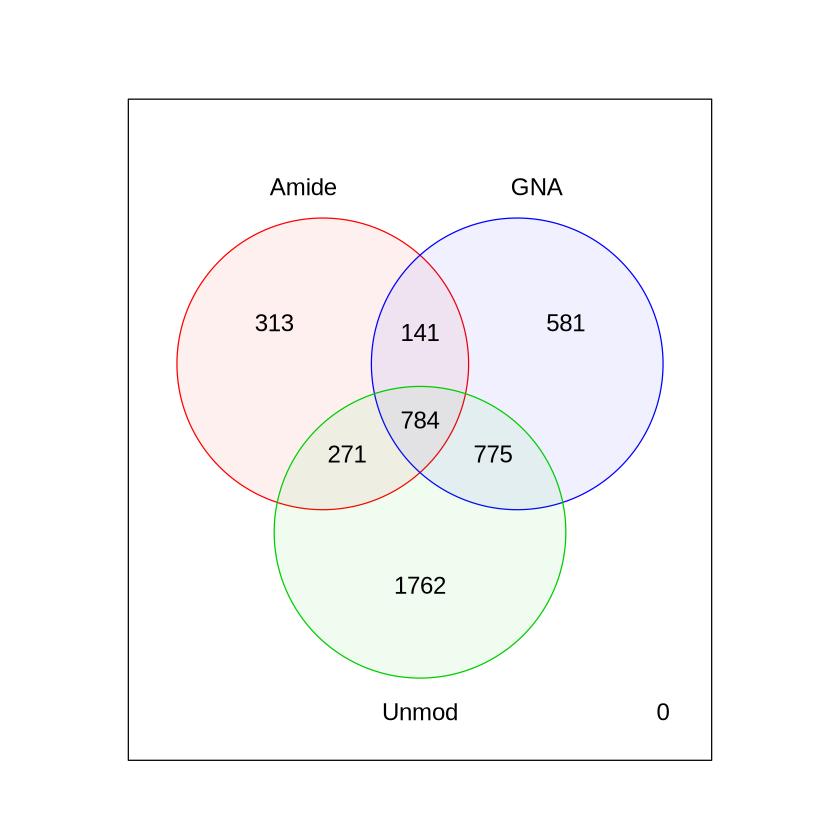

In [8]:
library(limma)

# Prepare the binary matrix
results <- matrix(0, nrow = length(unique(c(set_amide, set_gna, set_unmod))), ncol = 3)
rownames(results) <- unique(c(set_amide, set_gna, set_unmod))
colnames(results) <- c("Amide", "GNA", "Unmod")
results[rownames(results) %in% set_amide, "Amide"] <- 1
results[rownames(results) %in% set_gna, "GNA"] <- 1
results[rownames(results) %in% set_unmod, "Unmod"] <- 1

# Plot Venn diagram
vennDiagram(
  results,
  counts.col = "black",                       # Text color for counts
  circle.col = c("red", "blue", "green3"),    # Circle colors
  names = sub("-", "/\n", colnames(results)), # Format names
  mar = rep(0, 4),                            # Margins
  cex = c(1.2, 1, 0.7),                       # Size of counts and labels
  fontfamily = "Arial"                        # Font for counts
)


In [ ]:
library(VennDiagram)
library(grid)

venn.plot <- venn.diagram(
  x = list(
    Amide = set_amide,
    GNA = set_gna,
    Unmod = set_unmod
  ),
  filename = NULL,
  col = c("dodgerblue4", "deeppink4", "darkgreen"),  # Darker outline colors
  fill = c("skyblue", "pink1", "lightgreen"),  # Fill colors
  alpha = 0.5,
  cex = 2,  # Size of the numbers
  cat.cex = 0,  # No labels
  fontfamily = "Arial"  # Arial font for the numbers
)

grid.newpage()
grid.draw(venn.plot)


In [18]:


print(df_amide)
print(df_gna)
print(df_unmod)

                GeneID log2fc_amide            padj_amide
1      ENSG00000172380       -0.210                 0.001
12     ENSG00000225630       -1.633                 0.005
27     ENSG00000279348        1.037                 0.000
29     ENSG00000228253       -1.258                 0.000
31     ENSG00000198695       -1.189                 0.040
...                ...          ...                   ...
14105  ENSG00000153113        0.277  1.01322645438496e-05
14539  ENSG00000242265       -0.230  4.43501190087476e-05
14688  ENSG00000155506       -0.218  5.64885305681164e-05
14971  ENSG00000113384       -0.229  3.06965747930668e-06
15003  ENSG00000060237       -0.287  1.13828227050319e-07

[1509 rows x 3 columns]
                GeneID log2fc_gna              padj_gna
1      ENSG00000172380     -0.554  3.65544759573586e-22
2      ENSG00000140538     -1.776                 0.018
3      ENSG00000141837     -1.852                 0.033
4      ENSG00000082074     -2.049                 0.002